In [508]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def mean_portfolio(weights, *dataopt):
    """Calculate portfolio return"""
    mean_returns = dataopt[0]  # This is the array of expected returns for each asset
    portfolio_return = mean_returns.dot(weights)
    return portfolio_return

def std_portfolio(weights, *dataopt):
    """Calculate portfolio volatility (standard deviation)"""
    annualized_returns = dataopt[0]
    # Compute correlation matrix
    correlation_matrix = dataopt[1] 

    # Compute standard deviation (volatility)
    individual_volatility = dataopt[2]

    # Convert to diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D)) * 12
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    return portfolio_volatility

def sharpe_ratio(weights, *dataopt):
    """Calculate Sharpe Ratio"""
    mean_returns = dataopt[0]  # Expected annual returns (array)
    correlation_matrix = dataopt[1]  # Correlation matrix of asset returns
    individual_volatility = dataopt[2]  # Standard deviation (volatility) of each asset

    # Calculate portfolio return
    portfolio_return = np.dot(weights, mean_returns)

    # Convert individual volatilities to a diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix using correlation and standard deviations
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D)) * 12  # Annualized covariance

    # Compute portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    # Compute Sharpe Ratio
    sharpe = portfolio_return / portfolio_volatility
    return sharpe  # No negation since maximization is handled separately




def portfolio_optimization(monthly_returns, stock, last_month_volatility):
    """Optimize portfolio using Sharpe Ratio maximization"""
    annual_trading_months = 12
    observed_trading_months = monthly_returns.shape[0]
    
    # Annualized returns
    annualized_returns = (1 + monthly_returns).prod() ** (annual_trading_months / observed_trading_months) - 1

    # Annualized covariance matrix
    volatility = last_month_volatility
    cor_returns = monthly_returns.corr()
    
    # Prepare optimization inputs
    dataopt = (annualized_returns, cor_returns, volatility)
    num_assets = len(annualized_returns)
    
    # Initial equal weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Bounds (weights between 0 and 1 for long-only portfolios)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Constraint: Sum of weights must be 1
    constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)}  # Ensure portfolio weight is less than 100%
    ]

    
    # Perform optimization
    result = minimize(
        fun=lambda x, *dataopt: -sharpe_ratio(x, *dataopt),  # Negate return for maximization
        x0=initial_weights,
        args=dataopt,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    optimal_weights = dict(zip(stock, result.x))
    print("Optimal Portfolio Allocation max SR")
    for asset, weight in optimal_weights.items():
        print(f"{asset}: {weight:.2%}")  # Display as percentage with 2 decimal places
    
    # Portfolio metrics
    portfolio_return = mean_portfolio(result.x, *dataopt)
    portfolio_volatility = std_portfolio(result.x, *dataopt)
    sharpe = portfolio_return / portfolio_volatility
    
    print(f"\nExpected Annual Return: {portfolio_return:.2%}")
    print(f"Annual Volatility: {portfolio_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    return sharpe # Return optimal allocation

    
    # to use just write (optimal_weights = portfolio_optimization(sample_data))
    # sample_data is monthly return data


In [509]:
import pandas as pd

# Read clustered data
clustered_df = pd.read_csv(r"Output/models/clustered_df.csv")

# Remove the first column
clustered_df = clustered_df.iloc[:, 1:]

print(clustered_df) 


            Date   Stock  PredictedReturn  PredictedVolatility  Cluster
0     2024-01-31       A        -0.744057             0.102797        0
1     2024-01-31  AAON.O        -0.039090             0.101948        0
2     2024-01-31     AAP         0.630248             0.137507        0
3     2024-01-31  AAPL.O         6.281893             0.080092        3
4     2024-01-31  ABEO.O        -4.939540             0.238952        2
...          ...     ...              ...                  ...      ...
9510  2024-10-31     ZBH        -1.884281             0.076510        2
9511  2024-10-31    ZD.O        -0.798077             0.094849        2
9512  2024-10-31  ZEUS.O        -0.347221             0.156842        2
9513  2024-10-31  ZION.O        -2.849456             0.109860        2
9514  2024-10-31  ZYXI.O         0.427867             0.142379        0

[9515 rows x 5 columns]


In [511]:
import pandas as pd

# Function to pivot and replace NaN with 0
def pivot_and_fill(df, value_column):
    """Pivot the DataFrame and replace NaN with 0"""
    return df.pivot_table(
        index='Date',
        columns='Stock',
        values=value_column,
        aggfunc='first'
    ).fillna(0)  # This converts NaN to 0
    
def get_top10_by_market_cap(cluster_df):
    return (
        cluster_df.sort_values('Company Market Cap', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    
def add_market_cap_to_cluster(cluster_df, market_cap_df):
    """Merge cluster_df with market_cap_df to add 'Company Market Cap'."""
    return cluster_df.merge(
        market_cap_df,
        on='Stock',
        how='left'  # Keep all stocks even if market cap is missing
    )

def merging_data(return_cluster):


# 1. Load and prepare three_ff data
    three_ff = pd.read_csv("three_ff_cleaned_df.csv")
     # Convert dates and filter range
    three_ff['Date'] = pd.to_datetime(three_ff['Date'], format='%d-%m-%Y')
    three_ff = three_ff[(three_ff['Date'] >= '2022-01-01') & 
                       (three_ff['Date'] <= '2023-12-31')]
    
    # 2. Melt to match cluster format
    three_ff_melted = three_ff.melt(
        id_vars=['Date'],
        var_name='Stock',
        value_name='PredictedReturn'
    )
    
    # 3. Filter for Cluster 0 stocks only
    cluster0_stocks = return_cluster.columns.tolist()
    three_ff_filtered = three_ff_melted[three_ff_melted['Stock'].isin(cluster0_stocks)]
    
    # 4. Pivot to wide format
    three_ff_pivoted = three_ff_filtered.pivot(
        index='Date',
        columns='Stock',
        values='PredictedReturn'
    )
    
    # 5. Ensure return_cluster0 has DateTimeIndex
    return_cluster.index = pd.to_datetime(return_cluster.index)
    
    # 6. Combine DataFrames
    combined_df = pd.concat([three_ff_pivoted, return_cluster])
    
    # 7. Final processing
    combined_df = combined_df.sort_index()
    combined_df = combined_df.apply(pd.to_numeric, errors='coerce')

    return combined_df


    
def cluster_defining(date_str):

    # Read clustered data
    clustered_df = pd.read_csv(r"Output/models/clustered_df.csv")

    # Remove the first column
    clustered_df = clustered_df.iloc[:, 1:]

    # Convert 'Date' column to datetime objects
    clustered_df['Date'] = pd.to_datetime(clustered_df['Date'])

    # Filter data for the specific date
    filtered_df = clustered_df[clustered_df['Date'] == pd.to_datetime(date_str)]

    # Create dataframes for each cluster
    df_cluster0 = filtered_df[filtered_df['Cluster'] == 0]
    df_cluster1 = filtered_df[filtered_df['Cluster'] == 1]
    df_cluster2 = filtered_df[filtered_df['Cluster'] == 2]
    df_cluster3 = filtered_df[filtered_df['Cluster'] == 3]

    # Read the clustered data CSV file
    merged_df = pd.read_csv(r"Output/models/merged_data.csv")
    merged_df['Period'] = pd.to_datetime(merged_df['Period'])
    
    # Filter for 2024-10-31 data only
    oct_2024_data = merged_df[merged_df['Period'] == pd.to_datetime(date_str)]
    
    # Select only 'RIC' and 'Company Market Cap' columns and rename RIC to Stock
    mktfiltered_data = oct_2024_data[['RIC', 'Company Market Cap']].rename(columns={'RIC': 'Stock'})
    


        # Apply to all clusters (replace df_cluster0, df_cluster1, etc. with your actual DataFrames)
    df_cluster0_with_cap = add_market_cap_to_cluster(df_cluster0, mktfiltered_data)
    df_cluster1_with_cap = add_market_cap_to_cluster(df_cluster1, mktfiltered_data)
    df_cluster2_with_cap = add_market_cap_to_cluster(df_cluster2, mktfiltered_data)
    df_cluster3_with_cap = add_market_cap_to_cluster(df_cluster3, mktfiltered_data)
    
        # Apply to all clusters
    top10_cluster0 = get_top10_by_market_cap(df_cluster0_with_cap)
    top10_cluster1 = get_top10_by_market_cap(df_cluster1_with_cap)
    top10_cluster2 = get_top10_by_market_cap(df_cluster2_with_cap)
    top10_cluster3 = get_top10_by_market_cap(df_cluster3_with_cap)

        # 1. Get the list of top 10 stocks from each cluster
    top10_stocks_cluster0 = top10_cluster0['Stock'].unique().tolist()
    top10_stocks_cluster1 = top10_cluster1['Stock'].unique().tolist()
    top10_stocks_cluster2 = top10_cluster2['Stock'].unique().tolist()
    top10_stocks_cluster3 = top10_cluster3['Stock'].unique().tolist()
    
    # 2. Filter the original clustered_df for each cluster's top 10 stocks AND date <= target_date
    alldate_cluster0 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster0)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster1 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster1)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster2 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster2)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster3 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster3)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])

    
    # 3. Reset index for clean numbering
    alldate_cluster0.reset_index(drop=True, inplace=True)
    alldate_cluster1.reset_index(drop=True, inplace=True)
    alldate_cluster2.reset_index(drop=True, inplace=True)
    alldate_cluster3.reset_index(drop=True, inplace=True)
    

    
        # Process PredictedReturn (with NaN→0)
    return_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster1 = pivot_and_fill(alldate_cluster1[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster2 = pivot_and_fill(alldate_cluster2[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster3 = pivot_and_fill(alldate_cluster3[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    
    # Process PredictedVolatility (with NaN→0)
    volatility_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster1 = pivot_and_fill(alldate_cluster1[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster2 = pivot_and_fill(alldate_cluster2[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster3 = pivot_and_fill(alldate_cluster3[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    



        # Assuming volatility_cluster0, volatility_cluster1, etc. are pandas DataFrames
    endvol0 = volatility_cluster0.iloc[-1, :]  # Get the last row
    endvol1 = volatility_cluster1.iloc[-1, :]
    endvol2 = volatility_cluster2.iloc[-1, :]
    endvol3 = volatility_cluster3.iloc[-1, :]

    mergedcluster0 = merging_data(return_cluster0)/100
    mergedcluster1 = merging_data(return_cluster1)/100
    mergedcluster2 = merging_data(return_cluster2)/100
    mergedcluster3 = merging_data(return_cluster3)/100

    monthly_returns0 = mergedcluster0.tail(10)
    monthly_returns1 = mergedcluster1.tail(10)
    monthly_returns2 = mergedcluster2.tail(10)
    monthly_returns3 = mergedcluster3.tail(10)

        # Extract stock names (column headers) from each cluster
    stock_cluster0 = return_cluster0.columns.tolist()
    stock_cluster1 = return_cluster1.columns.tolist() 
    stock_cluster2 = return_cluster2.columns.tolist()
    stock_cluster3 = return_cluster3.columns.tolist()
   

    portfolio0 = portfolio_optimization(monthly_returns0, stock_cluster0, endvol0)
    portfolio1 = portfolio_optimization(monthly_returns1, stock_cluster1, endvol1)
    portfolio2 = portfolio_optimization(monthly_returns2, stock_cluster2, endvol2)
    portfolio3 = portfolio_optimization(monthly_returns3, stock_cluster3, endvol3)

    sharpe_ratios = {
    'Cluster 0': portfolio_optimization(monthly_returns0, stock_cluster0, endvol0),
    'Cluster 1': portfolio_optimization(monthly_returns1, stock_cluster1, endvol1),
    'Cluster 2': portfolio_optimization(monthly_returns2, stock_cluster2, endvol2),
    'Cluster 3': portfolio_optimization(monthly_returns3, stock_cluster3, endvol3)
    }
    
    # Convert to DataFrame
    sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
    print(sharpe_df)

    return sharpe_df







In [512]:
Oct2024 = cluster_defining('2024-10-31')
Sept2024 = cluster_defining('2024-09-30')
Aug2024 = cluster_defining('2024-08-31')
Jul2024 = cluster_defining('2024-07-31')
Jun2024 = cluster_defining('2024-06-30')
May2024 = cluster_defining('2024-05-31')
Apr2024 = cluster_defining('2024-04-30')
Mar2024 = cluster_defining('2024-03-31')
Feb2024 = cluster_defining('2024-02-29')
Jan2024 = cluster_defining('2024-01-31')

Optimal Portfolio Allocation max SR
AAPL.O: 54.23%
AMZN.O: 3.77%
LLY: 0.00%
MA: 0.00%
MSFT.O: 0.00%
NVDA.O: 42.00%
ORCL.K: 0.00%
UNH: 0.00%
WMT: 0.00%
XOM: 0.00%

Expected Annual Return: 81.68%
Annual Volatility: 21.66%
Sharpe Ratio: 3.77
Optimal Portfolio Allocation max SR
BBY: 10.00%
ENTG.O: 0.00%
HON.O: 0.00%
KR: 0.10%
ODFL.O: 0.00%
ON.O: 0.00%
PPG: 0.00%
SYK: 89.90%
TROW.O: 0.00%
VLO: 0.00%

Expected Annual Return: 23.70%
Annual Volatility: 18.60%
Sharpe Ratio: 1.27
Optimal Portfolio Allocation max SR
ADBE.O: 26.68%
ADI.O: 0.00%
ADP.O: 12.32%
AMGN.O: 0.00%
DE: 0.00%
HD: 15.76%
MRK: 34.38%
MU.O: 0.00%
PFE: 0.00%
UNP: 10.87%

Expected Annual Return: 12.00%
Annual Volatility: 15.46%
Sharpe Ratio: 0.78
Optimal Portfolio Allocation max SR
AIFF.O: 10.00%
CYTH.O: 0.00%
DOMH.O: 0.27%
ERNA.O: 85.70%
EYPT.O: 0.00%
GPUS.K: 0.03%
LNC: 4.01%
MAGN.K: 0.00%
STRM.O: 0.00%
WBA.O: 0.00%

Expected Annual Return: -59.68%
Annual Volatility: 160.08%
Sharpe Ratio: -0.37
Optimal Portfolio Allocation max S

In [513]:
#Extract Sharpe Ratio series for each month
SRoct2024 = Oct2024['Sharpe Ratio']
SRsept2024 = Sept2024['Sharpe Ratio']
SRaug2024 = Aug2024['Sharpe Ratio']
SRjul2024 = Jul2024['Sharpe Ratio']
SRjun2024 = Jun2024['Sharpe Ratio']
SRmay2024 = May2024['Sharpe Ratio']
SRapr2024 = Apr2024['Sharpe Ratio']
SRmar2024 = Mar2024['Sharpe Ratio']
SRfeb2024 = Feb2024['Sharpe Ratio']
SRjan2024 = Jan2024['Sharpe Ratio']

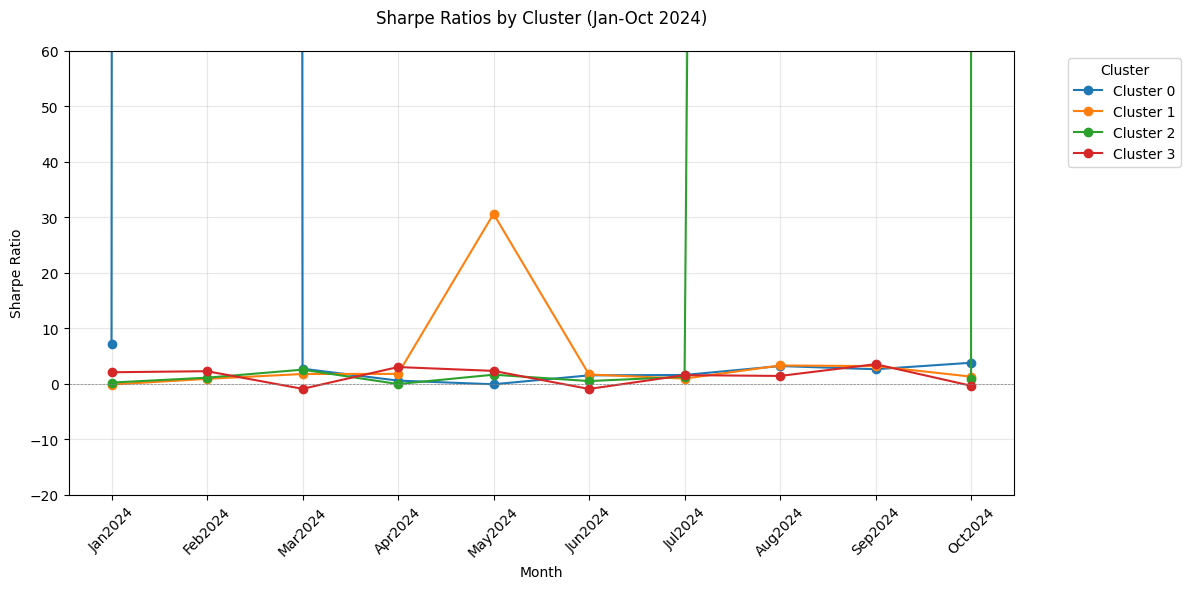

In [514]:
import matplotlib.pyplot as plt

# Combine all into one DataFrame for plotting
all_months = pd.DataFrame({
    'Jan2024': SRjan2024,
    'Feb2024': SRfeb2024,
    'Mar2024': SRmar2024,
    'Apr2024': SRapr2024,
    'May2024': SRmay2024,
    'Jun2024': SRjun2024,
    'Jul2024': SRjul2024,
    'Aug2024': SRaug2024,
    'Sep2024': SRsept2024,
    'Oct2024': SRoct2024
})

# Transpose to have months as rows and clusters as columns
all_months = all_months.T

# Plotting
plt.figure(figsize=(12, 6))
for cluster in all_months.columns:
    plt.plot(all_months.index, all_months[cluster], 
             marker='o', 
             label=f'Cluster {cluster[-1]}')

# Set fixed y-axis limits to -100 and 100
plt.ylim(bottom=-20, top=60)

# Highlight zero line for reference
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

# Formatting
plt.title('Sharpe Ratios by Cluster (Jan-Oct 2024)', pad=20)
plt.xlabel('Month')
plt.ylabel('Sharpe Ratio')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()